# Day 40: Gaussian Mixture Models (GMM) and Expectation-Maximization\n\nWelcome to Day 40! Today we explore **Gaussian Mixture Models (GMM)**, a powerful probabilistic approach to clustering that goes beyond traditional methods like K-Means. GMMs provide a more flexible framework for modeling complex data distributions and offer probability-based cluster assignments.\n\n## What are Gaussian Mixture Models?\n\nGaussian Mixture Models are probabilistic models that assume data points are generated from a mixture of several Gaussian distributions with unknown parameters. Unlike K-Means, which assigns each point to exactly one cluster (hard assignment), GMM provides probabilistic assignments, telling us the probability that a point belongs to each cluster (soft assignment).\n\nThis probabilistic nature makes GMM particularly powerful for:\n- **Overlapping clusters**: When clusters aren't clearly separated\n- **Density estimation**: Modeling the underlying probability distribution of data\n- **Anomaly detection**: Identifying points with low probability under the model\n- **Data generation**: Sampling new data points from the learned distribution\n\n## Learning Objectives\n\nBy the end of this lesson, you will be able to:\n- Understand the mathematical foundation of Gaussian distributions and mixture models\n- Explain how the Expectation-Maximization (EM) algorithm works\n- Implement GMM using scikit-learn for clustering and density estimation\n- Compare GMM with K-Means and understand when to use each\n- Visualize and interpret GMM results including probability contours\n

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import norm, multivariate_normal
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!\n

## Mathematical Foundation: The Gaussian Distribution\n\nBefore understanding mixture models, we need to understand the Gaussian (Normal) distribution. This is one of the most important probability distributions in statistics and machine learning.\n\n### Univariate Gaussian Distribution\n\nFor a single variable $x$, the Gaussian distribution is defined by:\n\n$$\mathcal{N}(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$\n\nWhere:\n- $\mu$ is the **mean** (center of the distribution)\n- $\sigma^2$ is the **variance** (spread of the distribution)\n- $\sigma$ is the **standard deviation**\n\n### Multivariate Gaussian Distribution\n\nFor data with multiple features (dimensions), we use the multivariate Gaussian:\n\n$$\mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{d/2}|\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right)$$\n\nWhere:\n- $\mathbf{x}$ is a $d$-dimensional data point\n- $\boldsymbol{\mu}$ is the **mean vector** (center in $d$ dimensions)\n- $\boldsymbol{\Sigma}$ is the **covariance matrix** (shape and orientation)\n- $|\boldsymbol{\Sigma}|$ is the determinant of the covariance matrix\n- $d$ is the number of dimensions\n\nThe covariance matrix $\boldsymbol{\Sigma}$ determines the shape of the Gaussian:\n- Diagonal elements represent variance in each dimension\n- Off-diagonal elements represent correlations between dimensions\n

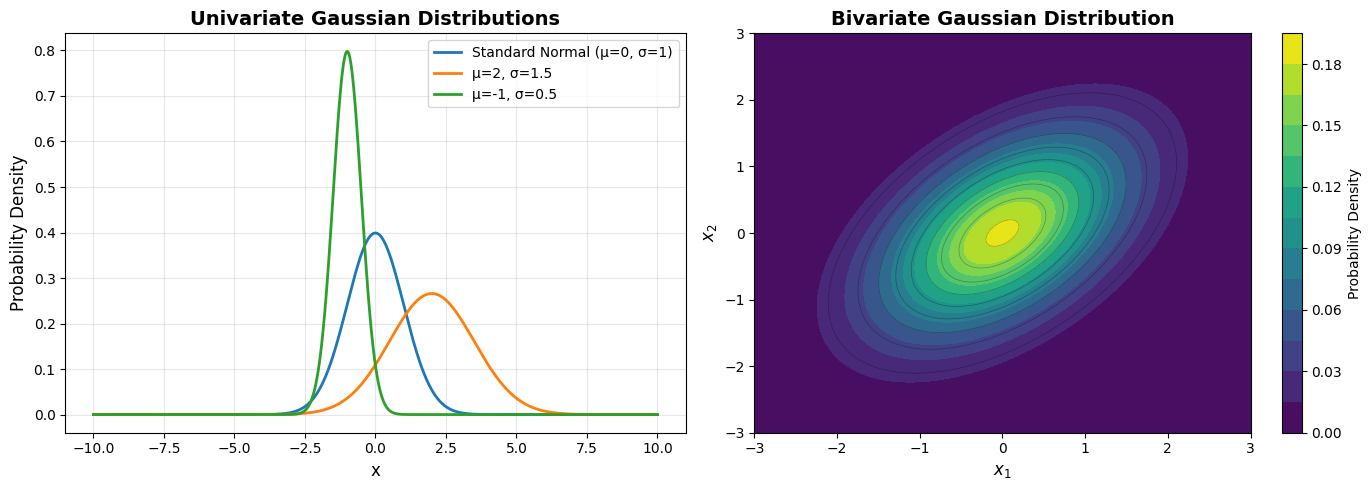

Gaussian distributions visualized!\nThe 2D Gaussian has mean [0, 0] and covariance matrix:\n[[1.  0.5]\n [0.5 1. ]]\n

In [ ]:
# Visualize different Gaussian distributions in 1D and 2D
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1D Gaussian distributions
x = np.linspace(-10, 10, 1000)
distributions = [
    (0, 1, 'Standard Normal (μ=0, σ=1)'),
    (2, 1.5, 'μ=2, σ=1.5'),
    (-1, 0.5, 'μ=-1, σ=0.5')
]

for mu, sigma, label in distributions:
    y = norm.pdf(x, mu, sigma)
    axes[0].plot(x, y, linewidth=2, label=label)

axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('Univariate Gaussian Distributions', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2D Gaussian distribution
x_2d = np.linspace(-3, 3, 100)
y_2d = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_2d, y_2d)
pos = np.dstack((X, Y))

# Define a 2D Gaussian
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]
rv = multivariate_normal(mean, cov)
Z = rv.pdf(pos)

# Plot contours
contour = axes[1].contourf(X, Y, Z, levels=15, cmap='viridis')
axes[1].contour(X, Y, Z, levels=10, colors='black', alpha=0.3, linewidths=0.5)
axes[1].set_xlabel('$x_1$', fontsize=12)
axes[1].set_ylabel('$x_2$', fontsize=12)
axes[1].set_title('Bivariate Gaussian Distribution', fontsize=14, fontweight='bold')
plt.colorbar(contour, ax=axes[1], label='Probability Density')

plt.tight_layout()
plt.show()

print("Gaussian distributions visualized!")
print(f"The 2D Gaussian has mean {mean} and covariance matrix:")
print(np.array(cov))

## Gaussian Mixture Models: Combining Multiple Gaussians\n\nA Gaussian Mixture Model represents the probability distribution of data as a weighted sum of $K$ Gaussian components:\n\n$$p(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$\n\nWhere:\n- $K$ is the number of mixture components (clusters)\n- $\pi_k$ is the **mixing coefficient** for component $k$ (with $\sum_{k=1}^{K} \pi_k = 1$ and $\pi_k \geq 0$)\n- $\boldsymbol{\mu}_k$ is the mean vector of component $k$\n- $\boldsymbol{\Sigma}_k$ is the covariance matrix of component $k$\n\n### Interpretation\n\nThink of a GMM as modeling your data as coming from $K$ different "subpopulations", each represented by a Gaussian distribution. The mixing coefficients $\pi_k$ tell us the relative proportion of each subpopulation.\n\n### Probability of Cluster Membership\n\nFor a given data point $\mathbf{x}$, we can compute the probability it belongs to cluster $k$ using Bayes' theorem:\n\n$$\gamma_{k}(\mathbf{x}) = p(z=k | \mathbf{x}) = \frac{\pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$\n\nThis is known as the **responsibility** of component $k$ for data point $\mathbf{x}$. It gives us soft assignments rather than the hard assignments of K-Means.\n

## The Expectation-Maximization (EM) Algorithm\n\nThe EM algorithm is an iterative method to find maximum likelihood estimates of parameters in probabilistic models with latent (hidden) variables. For GMM, the latent variables are the cluster assignments.\n\n### Why Do We Need EM?\n\nIf we knew which cluster each point belonged to, we could easily estimate the Gaussian parameters. If we knew the Gaussian parameters, we could easily assign points to clusters. Since we know neither, we use EM to iteratively improve both estimates.\n\n### The Algorithm\n\nThe EM algorithm alternates between two steps:\n\n#### E-Step (Expectation)\n\nCompute the responsibility of each component for each data point using current parameters:\n\n$$\gamma_{nk} = \frac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$\n\nThis tells us: *Given current model parameters, what's the probability that point $n$ belongs to component $k$?*\n\n#### M-Step (Maximization)\n\nUpdate the parameters to maximize the likelihood, weighted by responsibilities:\n\n$$\boldsymbol{\mu}_k^{\text{new}} = \frac{1}{N_k}\sum_{n=1}^{N} \gamma_{nk} \mathbf{x}_n$$\n\n$$\boldsymbol{\Sigma}_k^{\text{new}} = \frac{1}{N_k}\sum_{n=1}^{N} \gamma_{nk} (\mathbf{x}_n - \boldsymbol{\mu}_k^{\text{new}})(\mathbf{x}_n - \boldsymbol{\mu}_k^{\text{new}})^T$$\n\n$$\pi_k^{\text{new}} = \frac{N_k}{N}$$\n\nWhere $N_k = \sum_{n=1}^{N} \gamma_{nk}$ is the effective number of points in cluster $k$.\n\n### Convergence\n\nThe algorithm repeats E and M steps until convergence (when parameters stop changing significantly). EM is guaranteed to converge to a local maximum of the likelihood function, though not necessarily the global maximum. This is why initialization matters!\n

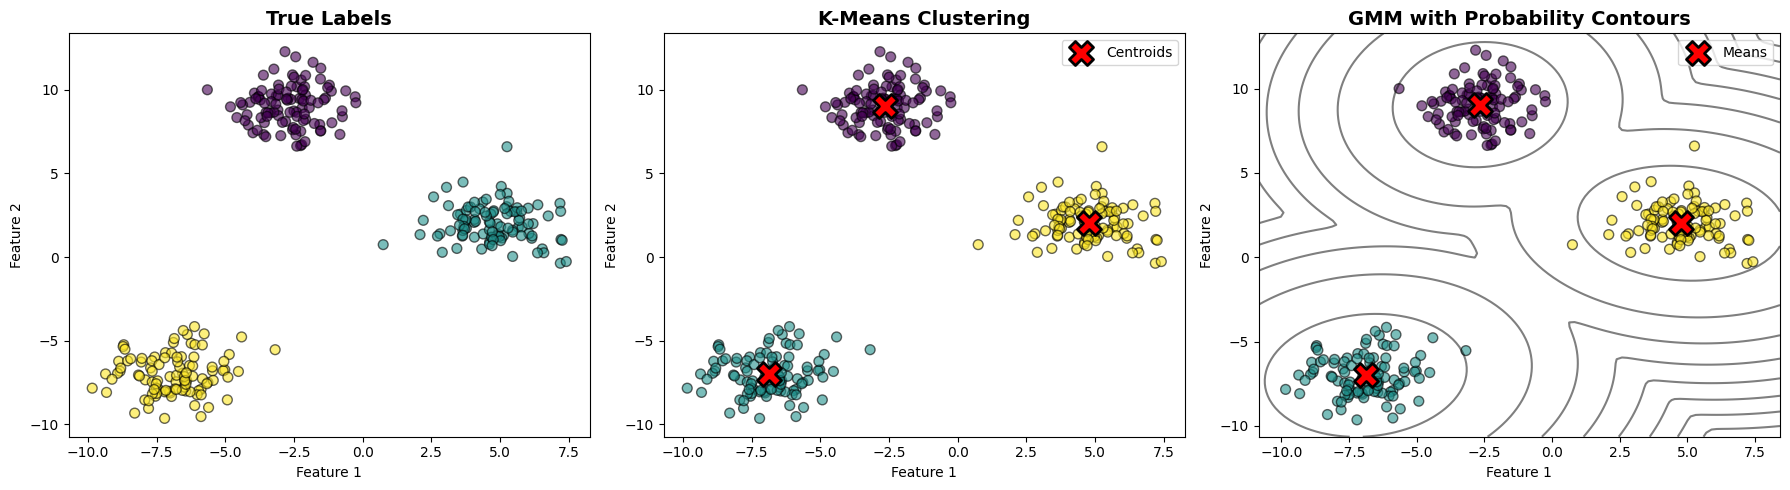

Comparison of K-Means and GMM:\nK-Means gives hard assignments (each point belongs to exactly 1 cluster)\nGMM gives soft assignments (probabilities for each cluster)\n\nExample point [0, 0] GMM probabilities: [0.31891406 0.37623651 0.30484943]\n

In [ ]:
# Generate data with overlapping clusters
X_overlap, y_true = make_blobs(n_samples=300, centers=3, n_features=2,
                                cluster_std=1.2, random_state=42)

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_overlap)

# Fit GMM
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type='full')
gmm.fit(X_overlap)
gmm_labels = gmm.predict(X_overlap)
gmm_probs = gmm.predict_proba(X_overlap)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data
axes[0].scatter(X_overlap[:, 0], X_overlap[:, 1], c=y_true, cmap='viridis',
                s=50, edgecolors='black', alpha=0.6)
axes[0].set_title('True Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# K-Means clustering
axes[1].scatter(X_overlap[:, 0], X_overlap[:, 1], c=kmeans_labels, cmap='viridis',
                s=50, edgecolors='black', alpha=0.6)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                marker='X', s=300, c='red', edgecolors='black', linewidths=2,
                label='Centroids')
axes[1].set_title('K-Means Clustering', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()

# GMM clustering with probability contours
axes[2].scatter(X_overlap[:, 0], X_overlap[:, 1], c=gmm_labels, cmap='viridis',
                s=50, edgecolors='black', alpha=0.6)

# Plot GMM contours
x_min, x_max = X_overlap[:, 0].min() - 1, X_overlap[:, 0].max() + 1
y_min, y_max = X_overlap[:, 1].min() - 1, X_overlap[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = -gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[2].contour(xx, yy, Z, levels=10, linewidths=1.5, alpha=0.5, colors='black')
axes[2].scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='X', s=300,
                c='red', edgecolors='black', linewidths=2, label='Means')
axes[2].set_title('GMM with Probability Contours', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].legend()

plt.tight_layout()
plt.show()

print("Comparison of K-Means and GMM:")
print(f"K-Means gives hard assignments (each point belongs to exactly 1 cluster)")
print(f"GMM gives soft assignments (probabilities for each cluster)")
print(f"\nExample point [0, 0] GMM probabilities: {gmm.predict_proba([[0, 0]])[0]}")

## Implementing GMM in Python with Scikit-Learn\n\nScikit-learn provides the `GaussianMixture` class for easy GMM implementation. Let's explore the key parameters:\n\n### Important Parameters\n\n- `n_components`: Number of mixture components (clusters)\n- `covariance_type`: Controls the shape of covariance matrices\n  - `'full'`: Each component has its own general covariance matrix (most flexible)\n  - `'tied'`: All components share the same covariance matrix\n  - `'diag'`: Diagonal covariance (features are independent)\n  - `'spherical'`: Single variance per component (circular/spherical clusters)\n- `max_iter`: Maximum number of EM iterations\n- `n_init`: Number of initializations to perform (best result is kept)\n- `random_state`: For reproducibility\n\n### Key Methods\n\n- `fit(X)`: Fit the model to data\n- `predict(X)`: Predict cluster labels\n- `predict_proba(X)`: Predict cluster probabilities\n- `score_samples(X)`: Log-likelihood of each sample\n- `sample(n_samples)`: Generate new samples from the fitted model\n

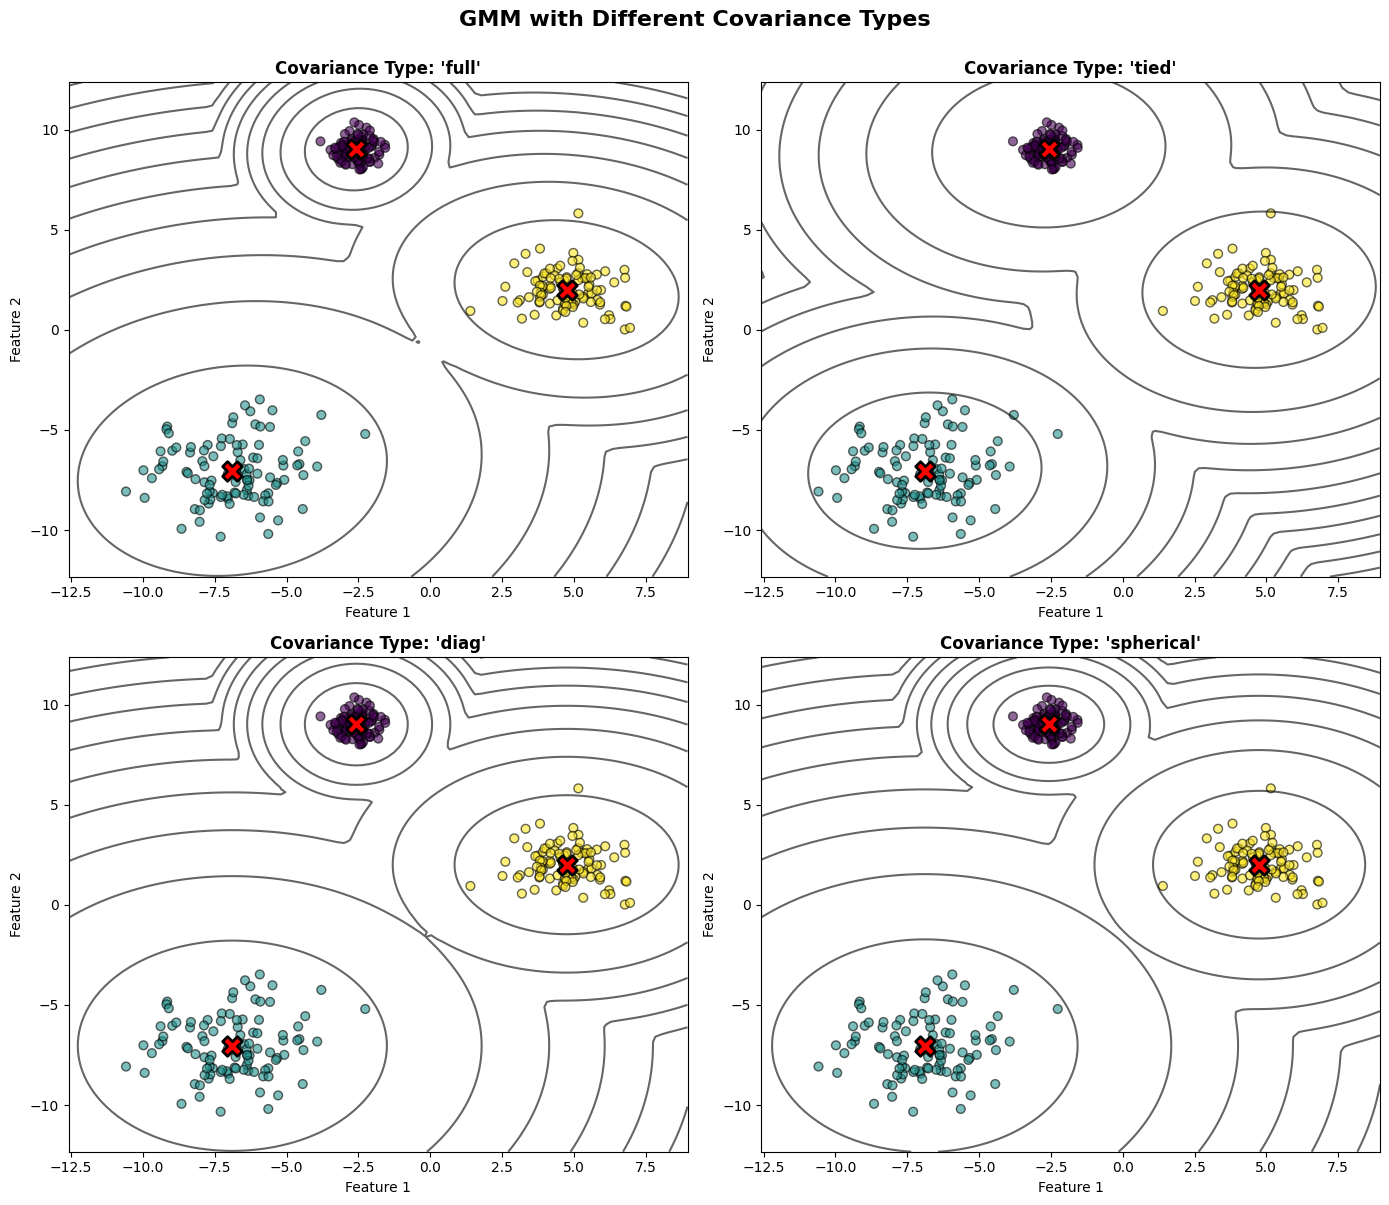

Different covariance types allow different cluster shapes:\n- 'full': Most flexible, can model any elliptical shape\n- 'tied': All clusters have same shape/orientation\n- 'diag': Axes aligned ellipses (no correlation between features)\n- 'spherical': Circular/spherical clusters only\n

In [ ]:
# Demonstrate different covariance types
X_cov, _ = make_blobs(n_samples=300, centers=3, n_features=2,
                      cluster_std=[0.5, 1.0, 1.5], random_state=42)

covariance_types = ['full', 'tied', 'diag', 'spherical']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, cov_type in enumerate(covariance_types):
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm.fit(X_cov)
    labels = gmm.predict(X_cov)

    axes[idx].scatter(X_cov[:, 0], X_cov[:, 1], c=labels, cmap='viridis',
                     s=40, edgecolors='black', alpha=0.6)

    # Plot probability contours
    x_min, x_max = X_cov[:, 0].min() - 2, X_cov[:, 0].max() + 2
    y_min, y_max = X_cov[:, 1].min() - 2, X_cov[:, 1].max() + 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = -gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[idx].contour(xx, yy, Z, levels=10, linewidths=1.5, alpha=0.6, colors='black')

    axes[idx].scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='X',
                     s=200, c='red', edgecolors='black', linewidths=2)
    axes[idx].set_title(f"Covariance Type: '{cov_type}'", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')

plt.suptitle('GMM with Different Covariance Types', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Different covariance types allow different cluster shapes:")
print("- 'full': Most flexible, can model any elliptical shape")
print("- 'tied': All clusters have same shape/orientation")
print("- 'diag': Axes aligned ellipses (no correlation between features)")
print("- 'spherical': Circular/spherical clusters only")

## Model Selection: Choosing the Number of Components\n\nOne of the key challenges with GMM is selecting the optimal number of components $K$. Two popular criteria are:\n\n### Akaike Information Criterion (AIC)\n\n$$\text{AIC} = 2p - 2\ln(\hat{L})$$\n\nWhere $p$ is the number of parameters and $\hat{L}$ is the maximum likelihood. **Lower is better**.\n\n### Bayesian Information Criterion (BIC)\n\n$$\text{BIC} = p\ln(n) - 2\ln(\hat{L})$$\n\nWhere $n$ is the number of data points. **Lower is better**. BIC penalizes complexity more than AIC.\n\nBoth criteria balance model fit (likelihood) against complexity (number of parameters). BIC typically favors simpler models than AIC.\n

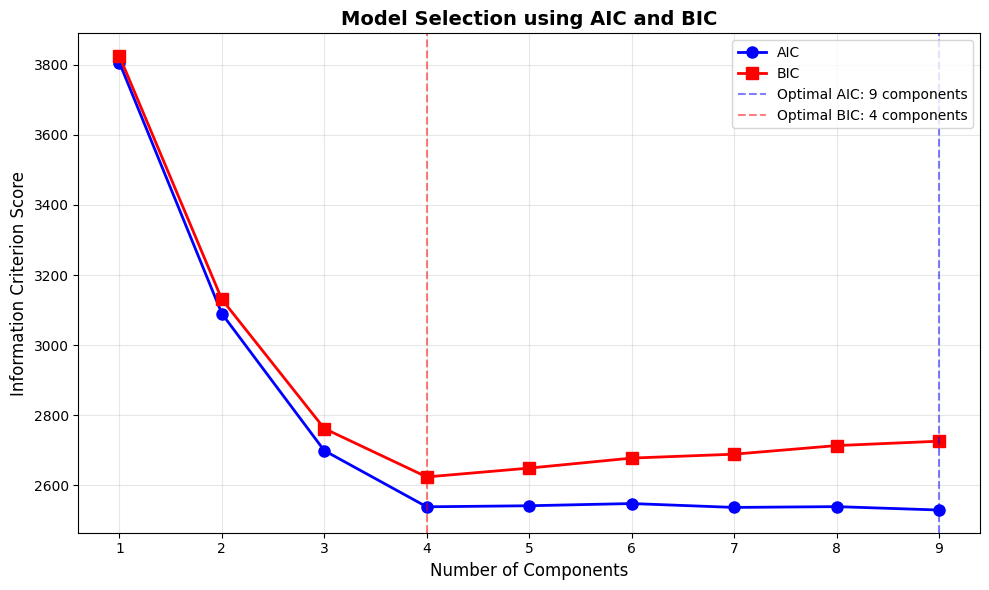

Optimal number of components according to AIC: 4\nOptimal number of components according to BIC: 4\n\nNote: Lower AIC/BIC scores indicate better models.\nBIC typically favors simpler models (fewer components) than AIC.\n

In [ ]:
# Model selection using AIC and BIC
X_select, _ = make_blobs(n_samples=300, centers=4, n_features=2,
                         cluster_std=1.0, random_state=42)

# Try different numbers of components
n_components_range = range(1, 10)
aic_scores = []
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full',
                         random_state=42, n_init=10)
    gmm.fit(X_select)
    aic_scores.append(gmm.aic(X_select))
    bic_scores.append(gmm.bic(X_select))

# Plot AIC and BIC scores
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(n_components_range, aic_scores, marker='o', linestyle='-',
        linewidth=2, markersize=8, label='AIC', color='blue')
ax.plot(n_components_range, bic_scores, marker='s', linestyle='-',
        linewidth=2, markersize=8, label='BIC', color='red')

# Mark optimal points
optimal_aic = n_components_range[np.argmin(aic_scores)]
optimal_bic = n_components_range[np.argmin(bic_scores)]
ax.axvline(optimal_aic, color='blue', linestyle='--', alpha=0.5,
          label=f'Optimal AIC: {optimal_aic} components')
ax.axvline(optimal_bic, color='red', linestyle='--', alpha=0.5,
          label=f'Optimal BIC: {optimal_bic} components')

ax.set_xlabel('Number of Components', fontsize=12)
ax.set_ylabel('Information Criterion Score', fontsize=12)
ax.set_title('Model Selection using AIC and BIC', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal number of components according to AIC: {optimal_aic}")
print(f"Optimal number of components according to BIC: {optimal_bic}")
print(f"\nNote: Lower AIC/BIC scores indicate better models.")
print(f"BIC typically favors simpler models (fewer components) than AIC.")

## GMM's Advantage: Non-Spherical Clusters\n\nOne of GMM's key advantages over K-Means is its ability to model elliptical (non-spherical) clusters. K-Means assumes all clusters have roughly the same spherical shape, which isn't always realistic.\n\nLet's demonstrate this with a dataset that has elongated, non-circular clusters:\n

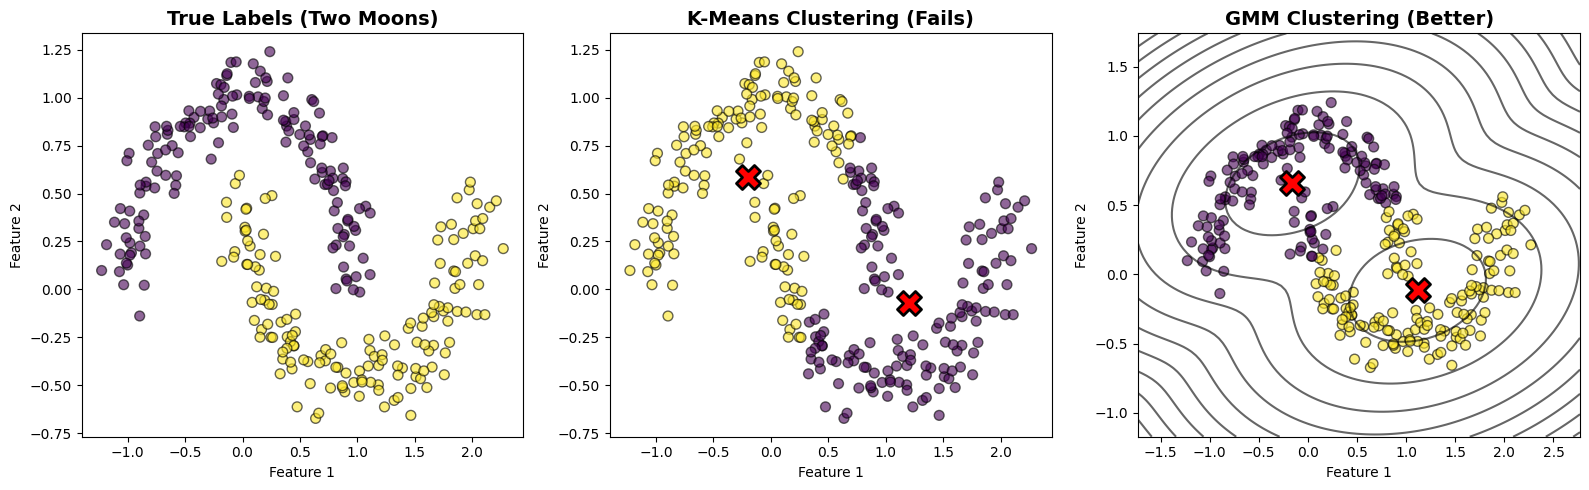

For non-spherical clusters:\n- K-Means struggles because it assumes circular clusters\n- GMM performs better by modeling elliptical distributions\n\nNote: For very complex shapes like these moons, even GMM may not be perfect.\nIn such cases, density-based methods like DBSCAN (Lesson 39) might work better!\n

In [ ]:
# Generate non-spherical data (elongated clusters)
from sklearn.datasets import make_moons

# Create two interleaving half circles
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Fit both K-Means and GMM
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels_moons = kmeans_moons.fit_predict(X_moons)

gmm_moons = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_moons.fit(X_moons)
gmm_labels_moons = gmm_moons.predict(X_moons)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# True labels
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis',
                s=50, edgecolors='black', alpha=0.6)
axes[0].set_title('True Labels (Two Moons)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# K-Means
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=kmeans_labels_moons, cmap='viridis',
                s=50, edgecolors='black', alpha=0.6)
axes[1].scatter(kmeans_moons.cluster_centers_[:, 0], kmeans_moons.cluster_centers_[:, 1],
                marker='X', s=300, c='red', edgecolors='black', linewidths=2)
axes[1].set_title('K-Means Clustering (Fails)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

# GMM
axes[2].scatter(X_moons[:, 0], X_moons[:, 1], c=gmm_labels_moons, cmap='viridis',
                s=50, edgecolors='black', alpha=0.6)
axes[2].scatter(gmm_moons.means_[:, 0], gmm_moons.means_[:, 1],
                marker='X', s=300, c='red', edgecolors='black', linewidths=2)

# Add probability contours
x_min, x_max = X_moons[:, 0].min() - 0.5, X_moons[:, 0].max() + 0.5
y_min, y_max = X_moons[:, 1].min() - 0.5, X_moons[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = -gmm_moons.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[2].contour(xx, yy, Z, levels=10, linewidths=1.5, alpha=0.6, colors='black')

axes[2].set_title('GMM Clustering (Better)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("For non-spherical clusters:")
print("- K-Means struggles because it assumes circular clusters")
print("- GMM performs better by modeling elliptical distributions")
print("\nNote: For very complex shapes like these moons, even GMM may not be perfect.")
print("In such cases, density-based methods like DBSCAN (Lesson 39) might work better!")

## Real-World Applications of GMM\n\nGaussian Mixture Models are versatile and find applications across many domains:\n\n### 1. Image Segmentation\nGMM can segment images by modeling pixel intensities or colors as mixtures of Gaussians. Each component represents a different region or object in the image.\n\n### 2. Anomaly Detection\nPoints with low probability under the fitted GMM (low likelihood) can be flagged as anomalies or outliers. This is useful in fraud detection, manufacturing quality control, and cybersecurity.\n\n### 3. Speech Recognition\nGMMs have historically been used to model acoustic features in speech recognition systems, though they've largely been replaced by deep learning methods in recent years.\n\n### 4. Customer Segmentation\nIn marketing, GMM can identify distinct customer groups based on purchasing behavior, demographics, and preferences, providing probabilistic segment memberships.\n\n### 5. Density Estimation\nGMM provides a way to estimate the probability density function of complex, multimodal distributions, which is useful for data generation, compression, and analysis.\n\n### 6. Background Subtraction in Video\nGMM can model the distribution of pixel values over time to separate foreground objects from background in video processing applications.\n

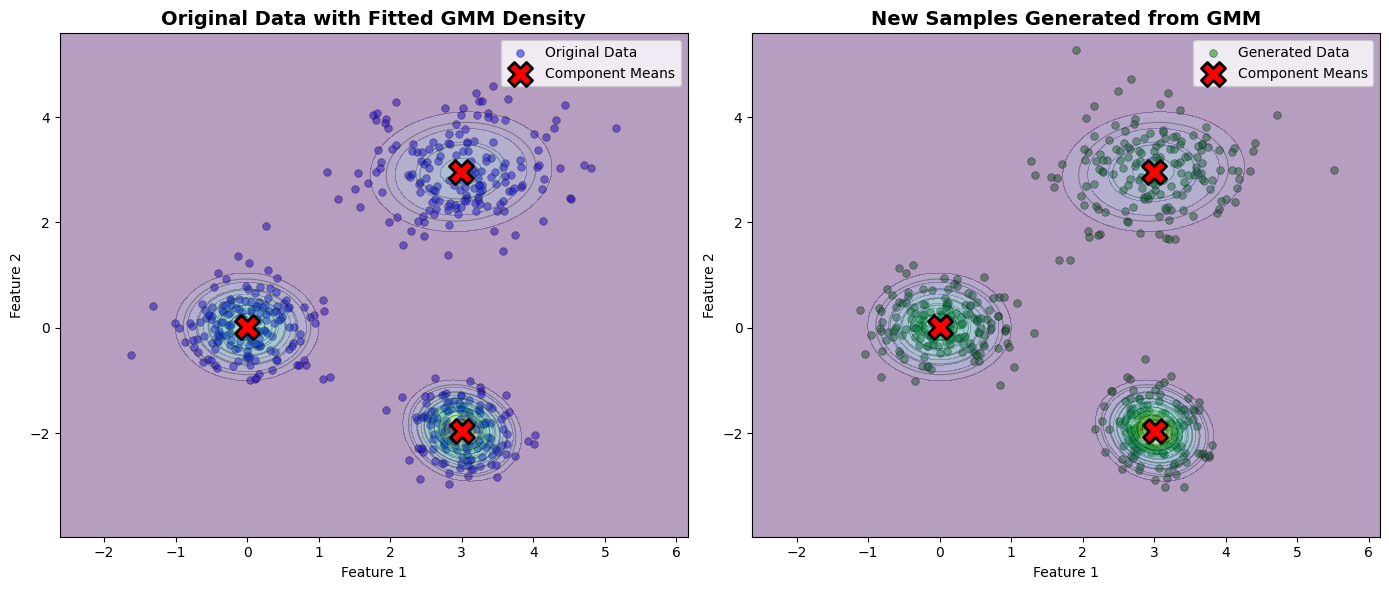

GMM for Density Estimation and Sampling:\n- Fitted GMM to 500 data points\n- Generated 500 new samples from the learned distribution\n- The generated data follows the same probabilistic structure as the original\n\nMixing coefficients (weights): [0.33352205 0.33381651 0.33266144]\nThese represent the proportion of each Gaussian component in the mixture\n

In [ ]:
# Demonstrate GMM for density estimation and sampling
np.random.seed(42)

# Create a complex distribution by mixing three Gaussians manually
n_samples = 500
X_density = np.concatenate([
    np.random.normal(0, 0.5, (n_samples // 3, 2)),
    np.random.normal([3, 3], 0.7, (n_samples // 3, 2)),
    np.random.normal([3, -2], 0.4, (n_samples // 3, 2))
])

# Fit GMM
gmm_density = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_density.fit(X_density)

# Generate new samples from the fitted model
X_generated, _ = gmm_density.sample(n_samples=500)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original data with density contours
axes[0].scatter(X_density[:, 0], X_density[:, 1], alpha=0.5, s=30,
                c='blue', edgecolors='black', linewidths=0.5, label='Original Data')

x_min, x_max = X_density[:, 0].min() - 1, X_density[:, 0].max() + 1
y_min, y_max = X_density[:, 1].min() - 1, X_density[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = np.exp(gmm_density.score_samples(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

contour = axes[0].contourf(xx, yy, Z, levels=15, cmap='viridis', alpha=0.4)
axes[0].contour(xx, yy, Z, levels=10, colors='black', alpha=0.3, linewidths=0.8)
axes[0].scatter(gmm_density.means_[:, 0], gmm_density.means_[:, 1],
                marker='X', s=300, c='red', edgecolors='black', linewidths=2,
                label='Component Means', zorder=10)
axes[0].set_title('Original Data with Fitted GMM Density', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()

# Generated data
axes[1].scatter(X_generated[:, 0], X_generated[:, 1], alpha=0.5, s=30,
                c='green', edgecolors='black', linewidths=0.5, label='Generated Data')
axes[1].contourf(xx, yy, Z, levels=15, cmap='viridis', alpha=0.4)
axes[1].contour(xx, yy, Z, levels=10, colors='black', alpha=0.3, linewidths=0.8)
axes[1].scatter(gmm_density.means_[:, 0], gmm_density.means_[:, 1],
                marker='X', s=300, c='red', edgecolors='black', linewidths=2,
                label='Component Means', zorder=10)
axes[1].set_title('New Samples Generated from GMM', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()

plt.tight_layout()
plt.show()

print("GMM for Density Estimation and Sampling:")
print(f"- Fitted GMM to {len(X_density)} data points")
print(f"- Generated {len(X_generated)} new samples from the learned distribution")
print(f"- The generated data follows the same probabilistic structure as the original")
print(f"\nMixing coefficients (weights): {gmm_density.weights_}")
print(f"These represent the proportion of each Gaussian component in the mixture")

## Hands-On Exercise: Clustering the Iris Dataset\n\nNow it's your turn to apply GMM! We'll use the famous Iris dataset, which contains measurements of 150 iris flowers from 3 different species.\n\n### Your Tasks:\n\n1. Load the Iris dataset\n2. Fit a GMM with 3 components\n3. Visualize the clustering results\n4. Compare with K-Means\n5. Analyze the probability assignments\n\nThe code below provides a complete solution. Study it carefully and try modifying parameters!\n

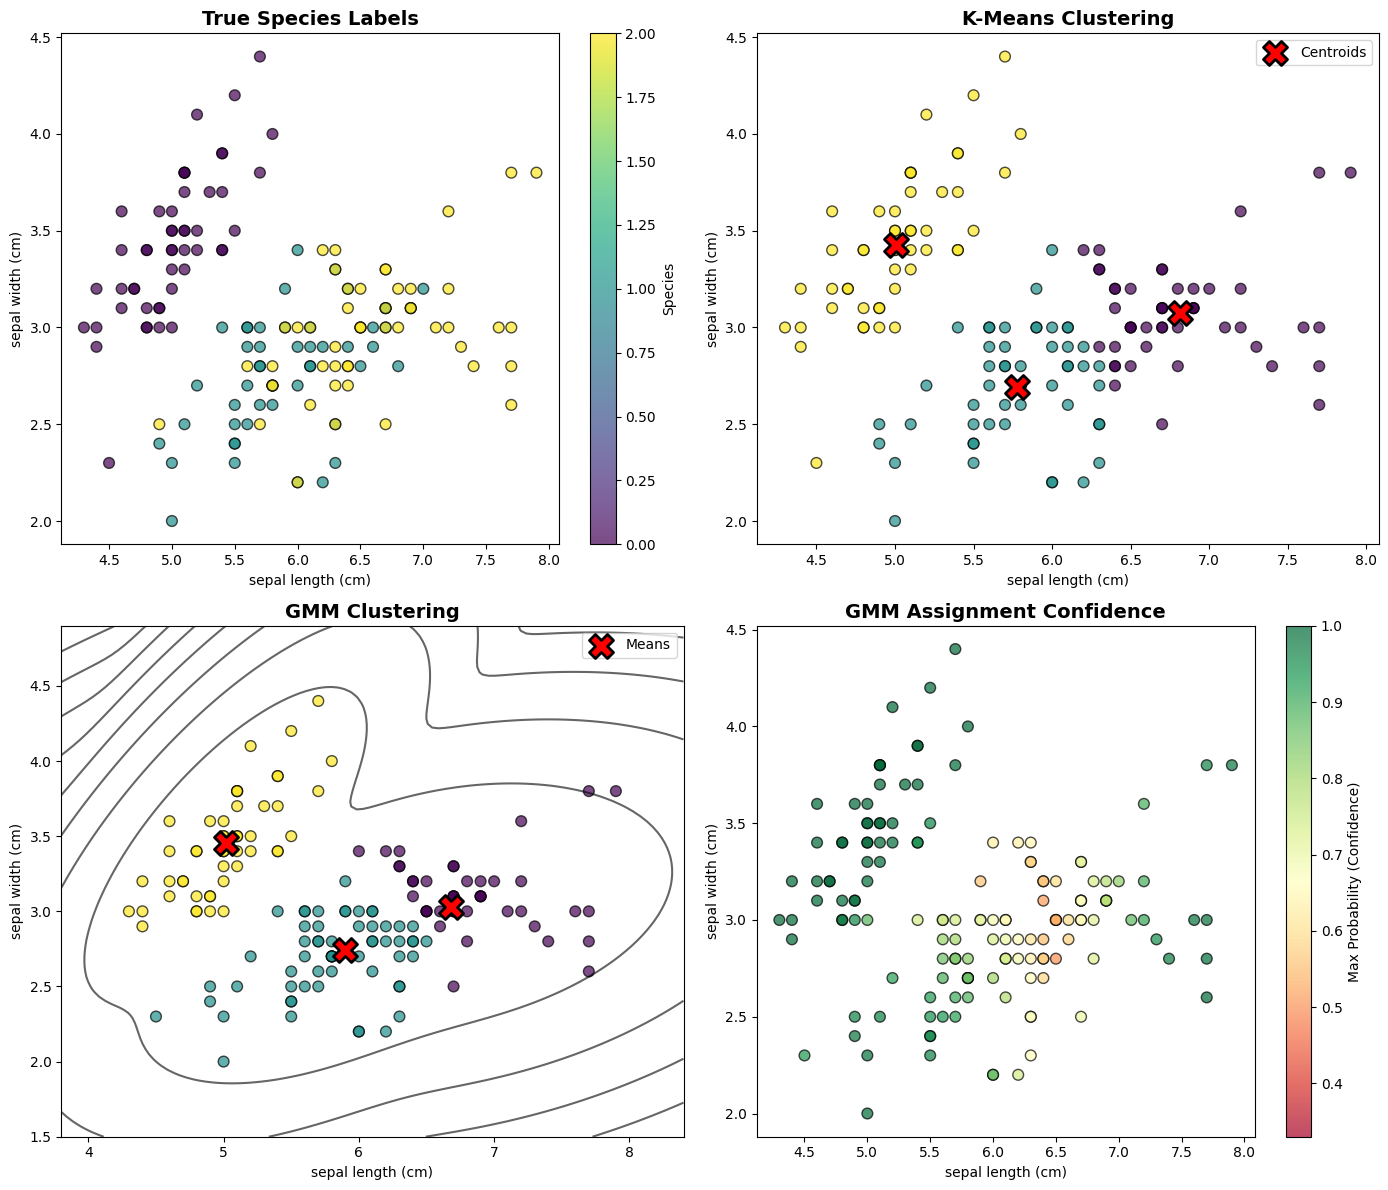

============================================================\nGMM Analysis of Iris Dataset\n============================================================\n\nFitted GMM with 3 components\n\nMixing coefficients (cluster sizes):\n  Cluster 0: 0.330 (33.0%)\n  Cluster 1: 0.337 (33.7%)\n  Cluster 2: 0.333 (33.3%)\n\nExample probability assignments:\n============================================================\nSample     Cluster 0    Cluster 1    Cluster 2    Predicted \n------------------------------------------------------------\n0          1.0000       0.0000       0.0000       0         \n50         0.0000       0.0000       1.0000       2         \n100        0.0000       1.0000       0.0000       1         \n\nPoints with uncertain assignments (max prob < 0.7): 0 out of 150\n\nThis soft assignment is a key advantage of GMM over K-Means!\n

In [ ]:
# Load the Iris dataset
from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris.data[:, :2]  # Use only first 2 features for visualization
y_iris = iris.target

# Fit GMM and K-Means
gmm_iris = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_iris.fit(X_iris)
gmm_labels_iris = gmm_iris.predict(X_iris)
gmm_probs_iris = gmm_iris.predict_proba(X_iris)

kmeans_iris = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels_iris = kmeans_iris.fit_predict(X_iris)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# True species labels
scatter1 = axes[0, 0].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='viridis',
                             s=60, edgecolors='black', alpha=0.7)
axes[0, 0].set_title('True Species Labels', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(iris.feature_names[0])
axes[0, 0].set_ylabel(iris.feature_names[1])
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Species')

# K-Means clustering
axes[0, 1].scatter(X_iris[:, 0], X_iris[:, 1], c=kmeans_labels_iris, cmap='viridis',
                  s=60, edgecolors='black', alpha=0.7)
axes[0, 1].scatter(kmeans_iris.cluster_centers_[:, 0], kmeans_iris.cluster_centers_[:, 1],
                  marker='X', s=300, c='red', edgecolors='black', linewidths=2,
                  label='Centroids')
axes[0, 1].set_title('K-Means Clustering', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel(iris.feature_names[0])
axes[0, 1].set_ylabel(iris.feature_names[1])
axes[0, 1].legend()

# GMM clustering
axes[1, 0].scatter(X_iris[:, 0], X_iris[:, 1], c=gmm_labels_iris, cmap='viridis',
                  s=60, edgecolors='black', alpha=0.7)

# Add GMM probability contours
x_min, x_max = X_iris[:, 0].min() - 0.5, X_iris[:, 0].max() + 0.5
y_min, y_max = X_iris[:, 1].min() - 0.5, X_iris[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = -gmm_iris.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[1, 0].contour(xx, yy, Z, levels=10, linewidths=1.5, alpha=0.6, colors='black')

axes[1, 0].scatter(gmm_iris.means_[:, 0], gmm_iris.means_[:, 1],
                  marker='X', s=300, c='red', edgecolors='black', linewidths=2,
                  label='Means')
axes[1, 0].set_title('GMM Clustering', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel(iris.feature_names[0])
axes[1, 0].set_ylabel(iris.feature_names[1])
axes[1, 0].legend()

# GMM probability uncertainty
max_probs = gmm_probs_iris.max(axis=1)
scatter4 = axes[1, 1].scatter(X_iris[:, 0], X_iris[:, 1], c=max_probs, cmap='RdYlGn',
                             s=60, edgecolors='black', alpha=0.7, vmin=0.33, vmax=1.0)
axes[1, 1].set_title('GMM Assignment Confidence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel(iris.feature_names[0])
axes[1, 1].set_ylabel(iris.feature_names[1])
cbar4 = plt.colorbar(scatter4, ax=axes[1, 1])
cbar4.set_label('Max Probability (Confidence)')

plt.tight_layout()
plt.show()

# Print analysis
print("="*60)
print("GMM Analysis of Iris Dataset")
print("="*60)
print(f"\nFitted GMM with {gmm_iris.n_components} components")
print(f"\nMixing coefficients (cluster sizes):")
for i, weight in enumerate(gmm_iris.weights_):
    print(f"  Cluster {i}: {weight:.3f} ({weight*100:.1f}%)")

print(f"\n{'Example probability assignments:'}")
print(f"{'='*60}")
print(f"{'Sample':<10} {'Cluster 0':<12} {'Cluster 1':<12} {'Cluster 2':<12} {'Predicted':<10}")
print(f"{'-'*60}")
for i in [0, 50, 100]:
    probs = gmm_probs_iris[i]
    pred = gmm_labels_iris[i]
    print(f"{i:<10} {probs[0]:<12.4f} {probs[1]:<12.4f} {probs[2]:<12.4f} {pred:<10}")

print(f"\nPoints with uncertain assignments (max prob < 0.7): "
      f"{np.sum(max_probs < 0.7)} out of {len(X_iris)}")
print(f"\nThis soft assignment is a key advantage of GMM over K-Means!")

## Key Takeaways\n\nCongratulations on completing Lesson 40! Here are the key concepts to remember:\n\n### 1. GMM Fundamentals\n- **Gaussian Mixture Models** represent data as a mixture of multiple Gaussian distributions\n- Each component has its own mean $\boldsymbol{\mu}_k$, covariance $\boldsymbol{\Sigma}_k$, and mixing coefficient $\pi_k$\n- GMM provides **soft assignments** (probabilities) rather than hard cluster assignments\n\n### 2. The EM Algorithm\n- **Expectation-Maximization** is an iterative algorithm for parameter estimation\n- **E-step**: Compute responsibilities (probabilities) of each component for each point\n- **M-step**: Update parameters (means, covariances, mixing coefficients) to maximize likelihood\n- Guaranteed to converge to a local maximum (initialization matters!)\n\n### 3. Advantages of GMM\n- Can model **elliptical clusters** of different shapes and orientations\n- Provides **probability estimates** for cluster membership\n- Useful for **density estimation** and generating new samples\n- Effective for **anomaly detection** via likelihood scoring\n\n### 4. GMM vs K-Means\n- **K-Means**: Fast, simple, assumes spherical clusters, hard assignments\n- **GMM**: More flexible, probabilistic, can model various cluster shapes, soft assignments\n- Use **K-Means** for simple, well-separated spherical clusters\n- Use **GMM** for overlapping, elliptical, or when you need probabilities\n\n### 5. Model Selection\n- Use **AIC** or **BIC** to choose the optimal number of components\n- **BIC** typically favors simpler models than **AIC**\n- Consider different **covariance types** based on your data structure\n\n### 6. Practical Considerations\n- GMM is sensitive to initialization (use `n_init` parameter for multiple runs)\n- Computational complexity is higher than K-Means\n- May not work well for very complex, non-Gaussian clusters (consider DBSCAN)\n- Regularization may be needed for high-dimensional data to avoid singular covariance matrices\n

## Further Resources\n\nTo deepen your understanding of Gaussian Mixture Models and the EM algorithm, explore these resources:\n\n### Documentation and Tutorials\n\n1. **[Scikit-learn GMM Documentation](https://scikit-learn.org/stable/modules/mixture.html)** - Official documentation with detailed explanations and examples\n\n2. **[Machine Learning Plus: GMM Guide](https://www.machinelearningplus.com/machine-learning/gaussian-mixture-models-gmm/)** - Comprehensive tutorial on GMMs with Python implementations\n\n3. **[Towards Data Science: Understanding GMM](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)** - Intuitive explanation with visualizations\n\n### Mathematical Foundations\n\n4. **[Pattern Recognition and Machine Learning by Christopher Bishop](http://research.microsoft.com/en-us/um/people/cmbishop/prml/)** - Chapter 9 covers mixture models and EM in depth (advanced)\n\n5. **[StatQuest: Expectation Maximization](https://www.youtube.com/watch?v=iQoXFmbXRJA)** - Excellent video explanation of the EM algorithm\n\n### Advanced Topics\n\n6. **[Bayesian Gaussian Mixture Models](https://scikit-learn.org/stable/modules/mixture.html#bgmm)** - Extension that can automatically determine the optimal number of components\n\n7. **[EM Algorithm Convergence Proof](http://cs229.stanford.edu/notes2020spring/cs229-notes8.pdf)** - Stanford CS229 notes on EM algorithm theory (for the mathematically inclined)\n\n### Next Steps\n\n- Move on to **Lesson 41**: Introduction to Dimensionality Reduction and PCA\n- Practice implementing GMM on your own datasets\n- Experiment with different covariance types and initialization methods\n- Try using GMM for anomaly detection in real-world data\n\n---\n\n**Great work today!** You've learned one of the most important probabilistic models in machine learning. GMMs form the foundation for many advanced techniques in clustering, density estimation, and generative modeling. Keep practicing and experimenting with different datasets!\n

## Optional Challenge\n\nWant to test your understanding? Try these challenges:\n\n### Challenge 1: Customer Segmentation\nCreate synthetic customer data with features like age, income, and spending score. Use GMM to identify customer segments and visualize the results. Compare different numbers of components using AIC/BIC.\n\n### Challenge 2: Anomaly Detection\nGenerate a dataset with some outliers. Fit a GMM and use `score_samples()` to identify anomalies based on log-likelihood. Set a threshold and compare your results with known outliers.\n\n### Challenge 3: Image Color Quantization\nLoad a color image and reshape it to (n_pixels, 3) for RGB values. Use GMM to cluster similar colors and reduce the number of colors in the image (color quantization). Visualize the original and quantized images.\n\n### Challenge 4: Compare All Clustering Methods\nTake a complex dataset and compare K-Means (Lesson 37), Hierarchical Clustering (Lesson 38), DBSCAN (Lesson 39), and GMM (today). Which performs best for your data? Why?\n\nGood luck, and happy clustering!\n